# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Plot showing distribution of images in train, validation, and test sets.
* Applied image augmentation
* Mapping of class indices for label prediction inference
* Creation and training of machine learning model.
* Saving the trained model.
* Plotting learning curve to visualize model performance..
* Evaluating model performance using a pickle file..
* Making predictions on a randomly chosen image file.




## Additional Comments | Insights | Conclusions

---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/pp5-mildew-detection')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('A prior version is in place; proceed with making a new version.')
    pass
else:
    os.makedirs(name=file_path)


A prior version is in place; proceed with making a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Count of Images in Train, Test, and Validation Datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




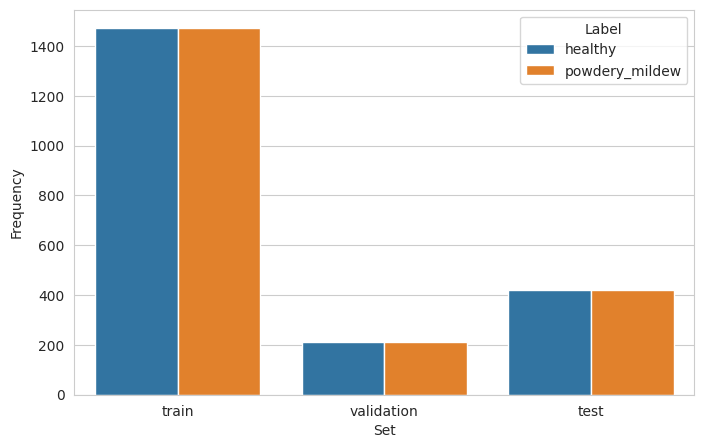

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [20]:
enhanced_img_data = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       rescale=1./255
                                       )

* ### Augment training image dataset

In [21]:
batch_size = 30  
train_set = enhanced_img_data.flow_from_directory(train_path,
                                                  target_size=image_shape[:2],
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True
                                                  )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [22]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [23]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(30, 256, 256, 3)


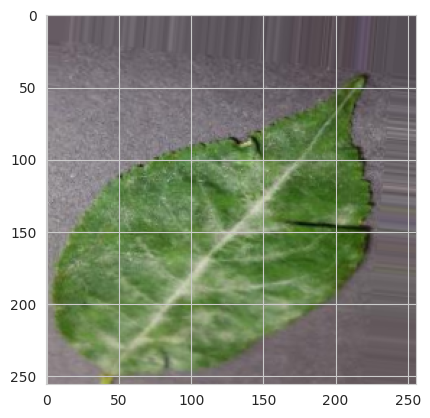

(30, 256, 256, 3)


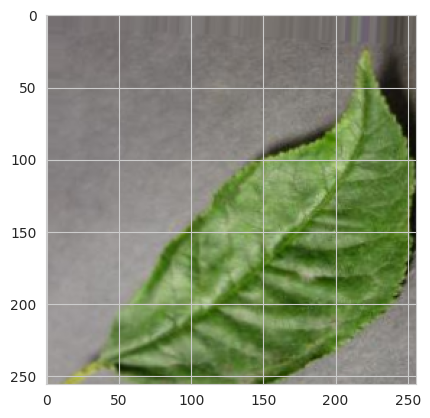

(30, 256, 256, 3)


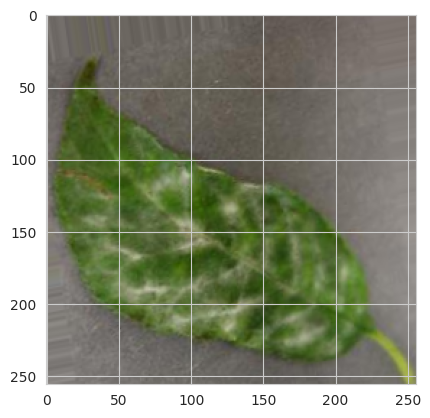

In [24]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(30, 256, 256, 3)


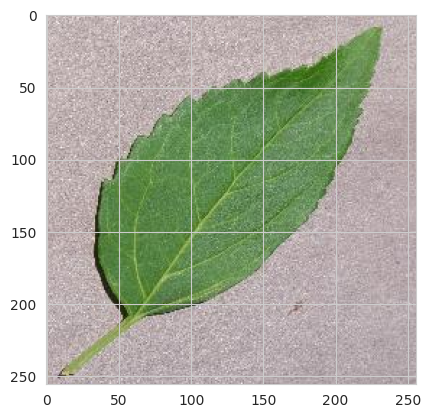

(30, 256, 256, 3)


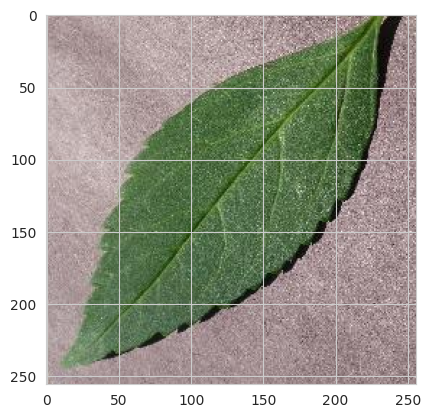

(30, 256, 256, 3)


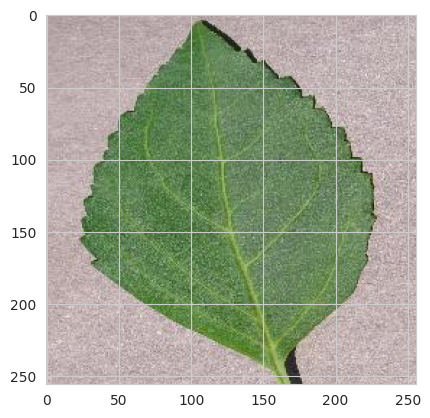

In [25]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(30, 256, 256, 3)


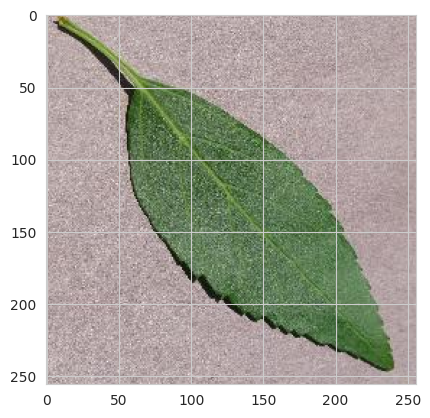

(30, 256, 256, 3)


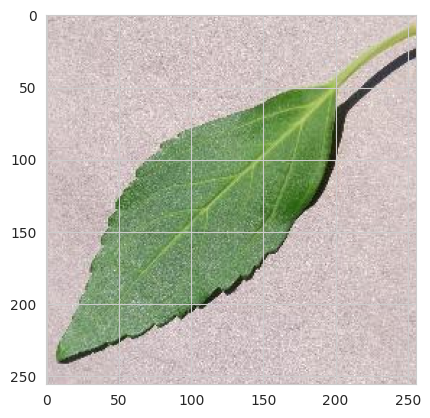

(30, 256, 256, 3)


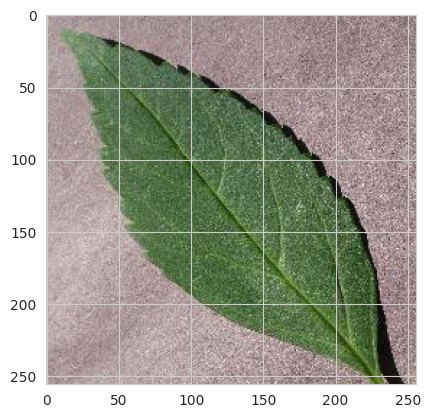

In [26]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [27]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---